Imports

In [1]:
import sys
sys.path.insert(0, "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/")
from pathlib import Path
import torch
import matplotlib.pyplot as plt 
from morphing_lander.data_utils.data_utils import get_data_from_rosbag, train_val_split
from morphing_lander.cvae.train import TrainConfig, train

Get dataset ready for training

In [2]:
# get data from rosbag
bag_path    = '/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_05_21-16_47_41'
type_path   = '/home/m4pc/m4v2-code/m4_ws/src/custom_msgs/msg/MPCStatus.msg'
topic_name  = 'mpc_status'

percent_val = 0.1
data = get_data_from_rosbag(bag_path,type_path,topic_name)

# split data into train and validation set
train_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/train_data.pt"
val_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/val_data.pt"

state_idx = [2,3,4,5,6,7,8] # train on z,thetaz,thetay,thetax,xdot,ydot,zdot # also phi but this is included automatically
input_idx = [0,1,2,3]       # train on 4 thruster PWMs
train_data, val_data = train_val_split(data,percent_val,state_idx,input_idx)

# save train and validation data for future use
torch.save(train_data, train_data_path)
torch.save(val_data, val_data_path)

print(f"training data points: {train_data.shape[0]}")
print(f"validation data points: {val_data.shape[0]}")


training data points: 14332
validation data points: 1592


In [3]:
import plotly.graph_objects as go

d     = data['d']
f_res = data['f_res']
x_vec = data['x_vec']
x_ref_vec = data['x_ref_vec']
x_next_vec = data['x_next_vec']
u_vec = data['u_vec']
phi_vec = data['phi_vec']
t_vec = data['t_vec']
dt_vec = data['dt_vec']

plt.figure()
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x_vec[:,2],
        y=f_res[:,8],
        name="Actual",
        line=dict(color="blue"),
        # fill="blue",
    )
)

# fig.add_trace(
#     go.Scatter(
#         x=x_vec[:,2],
#         y=f_res[:,8],
#         name="Model one step prediction",
#         line=dict(color="red"),
#     )
# )

<Figure size 640x480 with 0 Axes>

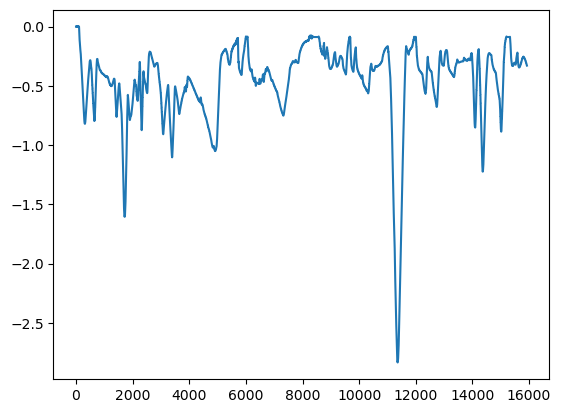

In [4]:
plt.plot(x_vec[:,2])

Specify training configuration

In [3]:
# Specify the path for the learned models
output_path = Path(
    "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/"
)

train_config = TrainConfig(
    output_dim=12,
    latent_dim=6,
    cond_dim=12,
    encoder_layers=[32, 32],
    decoder_layers=[32, 32],
    prior_layers=[32, 32],
    batches_per_epoch=10,
    epochs=200,
    step_size=50,  # steps per decay for lr scheduler
    gamma=0.75,  # multiplicative decay for lr scheduler
    lr=5e-4,
    save_epochs=10,
    val_epochs=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print(f"Device is: {train_config.device}")

Device is: cpu


/home/m4pc/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Train

In [4]:

model = train(train_data_path,val_data_path,train_config,output_path)

Epoch 0: train_loss=18.14868927001953, val_loss=17.424525260925293
Epoch 10: train_loss=12.935943603515625, val_loss=15.311205387115479
Epoch 20: train_loss=9.56254768371582, val_loss=12.505503177642822
Epoch 30: train_loss=9.316575050354004, val_loss=5.27480936050415
Epoch 40: train_loss=2.982923746109009, val_loss=3.8965829610824585
Epoch 50: train_loss=-3.70481276512146, val_loss=2.7526148557662964
Epoch 60: train_loss=-4.9191975593566895, val_loss=1.8727777600288391
Epoch 70: train_loss=6.502128601074219, val_loss=1.9114827513694763
Epoch 80: train_loss=-1.0724921226501465, val_loss=1.4825400412082672
Epoch 90: train_loss=-6.099163055419922, val_loss=2.8955475091934204
Epoch 100: train_loss=10.41487979888916, val_loss=3.8101033717393875
Epoch 110: train_loss=10.883554458618164, val_loss=0.45240430533885956
Epoch 120: train_loss=1.401294469833374, val_loss=3.7427580803632736
Epoch 130: train_loss=15.64484977722168, val_loss=0.9883191734552383
Epoch 140: train_loss=-7.120082855224609